In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import tensorflow as tf

from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

K.clear_session()

np.random.seed(237)

Using TensorFlow backend.


In [2]:


train_orig = pd.read_csv('train.csv')
test_orig = pd.read_csv('test.csv')

train_orig.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
train_orig = train_orig[train_orig.label == 0]

In [5]:
train_orig.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
test_orig.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# create 'label' column in test dataset; rearrange so that columns are in the same order as in train
test_orig['label'] = 11
testCols = test_orig.columns.tolist()
testCols = testCols[-1:] + testCols[:-1]
test_orig = test_orig[testCols]

In [7]:
# combine original train and test sets
#combined = pd.concat([train_orig, test_orig], ignore_index = True)
combined = train_orig
combined.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
combined.tail()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41952,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41954,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41960,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41991,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# Hold out 5000 random images as a validation/test sample
valid = combined.sample(n = 1000, random_state = 555)
train = combined.loc[~combined.index.isin(valid.index)]

# free up some space and delete test and combined
#del train_orig, test_orig, combined

valid.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
18691,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38555,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7238,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15565,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# X's
X_train = train.drop(['label'], axis = 1)
X_valid = valid.drop(['label'], axis = 1)

# labels
y_train = train['label']
y_valid = valid['label']

# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.values.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.values.reshape(-1,28,28,1)

IndexError: ignored

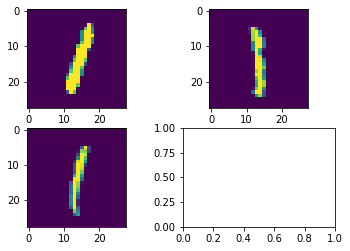

In [9]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42013][:,:,0])
plt.show()

In [0]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

In [0]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

In [0]:
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [0]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [14]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

In [15]:
vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=7,
        batch_size=batch_size,
        validation_data=(X_valid, None))

Train on 3132 samples, validate on 1000 samples
Epoch 1/7
3132/3132 [==============================] - 4s 1ms/step - loss: 0.2813 - val_loss: 0.2414
Epoch 2/7
3132/3132 [==============================] - 1s 439us/step - loss: 0.2158 - val_loss: 0.2003
Epoch 3/7
3132/3132 [==============================] - 1s 445us/step - loss: 0.1984 - val_loss: 0.1909
Epoch 4/7
3132/3132 [==============================] - 1s 428us/step - loss: 0.1921 - val_loss: 0.1889
Epoch 5/7
3132/3132 [==============================] - 1s 427us/step - loss: 0.1887 - val_loss: 0.1859
Epoch 6/7
3132/3132 [==============================] - 1s 425us/step - loss: 0.1866 - val_loss: 0.1863
Epoch 7/7
3132/3132 [==============================] - 1s 421us/step - loss: 0.1850 - val_loss: 0.1839


In [0]:
# Isolate original training set records in validation set
valid_noTest = valid[valid['label'] != 11]

# X's and Y's
X_valid_noTest = valid_noTest.drop('label', axis=1)
y_valid_noTest = valid_noTest['label']

# Reshape and normalize
X_valid_noTest = X_valid_noTest.astype('float32') / 255.
X_valid_noTest = X_valid_noTest.values.reshape(-1,28,28,1)

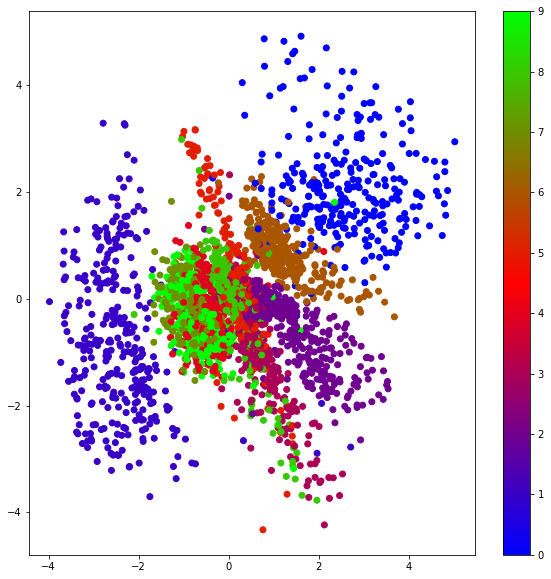

In [0]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(X_valid_noTest, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_valid_noTest, cmap='brg')
plt.colorbar()
plt.show()

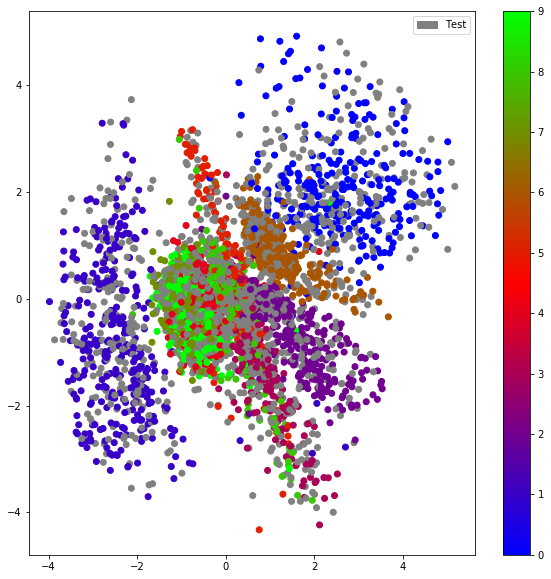

In [0]:
# set colormap so that 11's are gray
custom_cmap = matplotlib.cm.get_cmap('brg')
custom_cmap.set_over('gray')

x_valid_encoded = encoder.predict(X_valid, batch_size=batch_size)
plt.figure(figsize=(10, 10))
gray_marker = mpatches.Circle(4,radius=0.1,color='gray', label='Test')
plt.legend(handles=[gray_marker], loc = 'best')
plt.scatter(x_valid_encoded[:, 0], x_valid_encoded[:, 1], c=y_valid, cmap=custom_cmap)
plt.clim(0, 9)
plt.colorbar()

### *Samples in the latent space


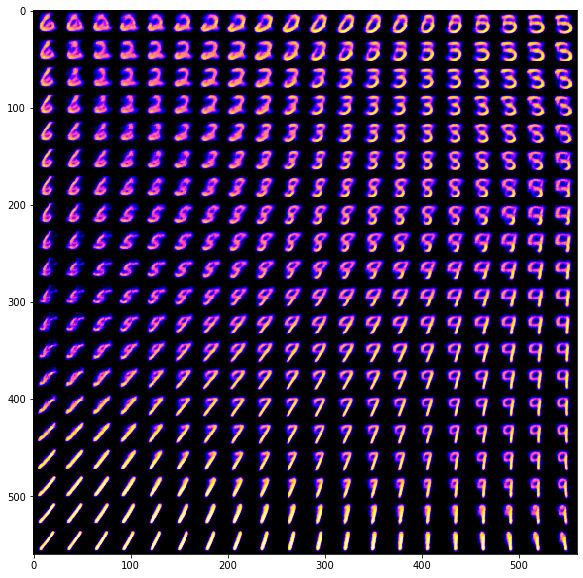

In [50]:
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  

##Playground begins here

In [0]:
vae09 = vae
zmu09 = z_mu
zls09 = z_log_sigma

In [0]:
z_mu+0.05

<tf.Tensor 'add:0' shape=(?, 2) dtype=float32>

In [18]:
#test = np.concatenate(test_orig)
encoder = Model(input_img, [z_mu, z_log_sigma])
latent = encoder.predict(X_valid_noTest, batch_size = batch_size)
latent_mean = np.mean(latent, axis=1)
latent_mean

array([[-0.22976816, -0.80627304],
       [-3.2140517 , -3.3009396 ]], dtype=float32)

In [0]:
mean09 = latent_mean[0]
sigmas09 = latent_mean[1]


In [0]:
mean19 = latent_mean[0]
sigmas19 = latent_mean[1]
mean19

array([0.5673103 , 0.10298061], dtype=float32)

In [0]:
variance_x_p

29.37125387674689

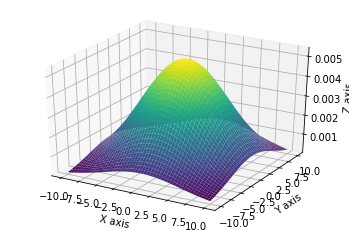

In [0]:
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

mu_x_p = mean19[0] - mean09[0]
variance_x_p = (sigmas19[0]**2) + (sigmas09[0] ** 2)

mu_y_p = mean19[0] - mean09[1]
variance_y_p = (sigmas19[0]**2) + (sigmas09[1]**2)


x = np.linspace(-10,10,500)
y = np.linspace(-10,10,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal([mu_x_p, mu_y_p], [[variance_x_p, 0], [0, variance_y_p]])

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [0]:
sigmas0

array([10.048367, 12.675627], dtype=float32)

In [19]:
mean0 = latent_mean[0]
sigmas0 = latent_mean[1]**2
sigmas0

array([10.330129, 10.896202], dtype=float32)

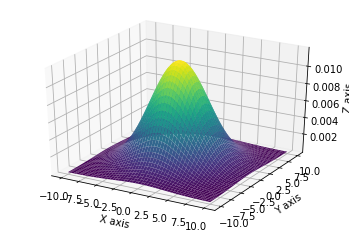

In [0]:
x = np.linspace(-10,10,500)
y = np.linspace(-10,10,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal(mean0, [[sigmas0[0], 0], [0, sigmas0[1]]])

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

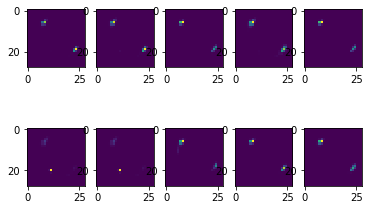

In [61]:
#sampling from the latent distribution 
delta = 0.05
varis = latent_mean[1]**2
samples = []
plt.figure(2)
for i in range(10):

  x = np.random.multivariate_normal(mean0+15,[[varis[0], 0], [0, varis[1]]] , 1)
  x = np.tile(x, batch_size).reshape(batch_size,2)
  xd = decoder.predict(x, batch_size=batch_size)
  
  plt.subplot(2,5,i+1)
  plt.imshow(xd[0][:,:,0])
  


In [0]:
#average similarity between 100 pairs of inputs 
amse=0
assim=0

for i in range(100):
  x = np.random.multivariate_normal(mean0+15,[[varis[0], 0], [0, varis[1]]] , 1)
  x = np.tile(x, batch_size).reshape(batch_size,2)
  xd = decoder.predict(x, batch_size=batch_size)

  y = np.random.multivariate_normal(mean0+15,[[varis[0], 0], [0, varis[1]]] , 1)
  y = np.tile(y, batch_size).reshape(batch_size,2)
  yd = decoder.predict(y, batch_size=batch_size)
  amse = amse + mse(xd, yd)
  assim = assim + measure.compare_ssim(xd,yd, multichannel=True)

amse = amse/100
assim = assim/100

In [39]:
amse

2.2534109901783426

In [0]:
avgmse=[]
avgssim=[]

In [0]:
avgmse.append(amse)
avgssim.append(assim)

Text(0, 0.5, 'Average mean squared error')

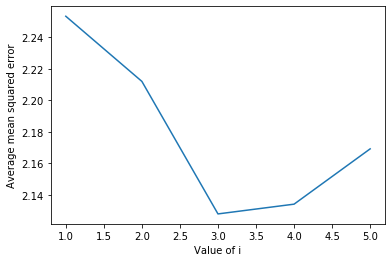

In [51]:
i = [1, 2, 3, 4, 5]
plt.plot(i, avgmse)
plt.xlabel('Value of i')
plt.ylabel('Average mean squared error')

Text(0, 0.5, 'Average SSIM')

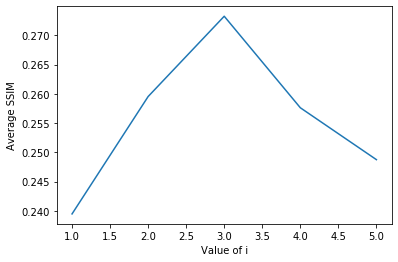

In [52]:
i = [1, 2, 3, 4, 5]
plt.plot(i, avgssim)
plt.xlabel('Value of i')
plt.ylabel('Average SSIM')

In [0]:
#X_samples = valid.drop(['label'], axis = 1)
#y_samples = valid['label']
#X_samples = X_samples.astype('float32') / 255.
#X_samples = X_samples.values.reshape(-1,28,28,1)

X_samples = X_valid[:100]
y_samples = y_valid[:100]

In [0]:
X_samples.shape
#X_samples

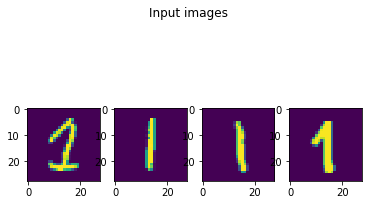

In [64]:
plt.figure(1)
plt.suptitle('Input images')
plt.subplot(141)
plt.imshow(X_samples[22][:,:,0])
plt.subplot(142)
plt.imshow(X_samples[43][:,:,0])
plt.subplot(143)
plt.imshow(X_samples[64][:,:,0])
plt.subplot(144)
plt.imshow(X_samples[60][:,:,0])

Xdisplay = []
Xdisplay.append(X_samples[22][:,:,0])
Xdisplay.append(X_samples[43][:,:,0])
Xdisplay.append(X_samples[64][:,:,0])
Xdisplay.append(X_samples[60][:,:,0])

Input Images


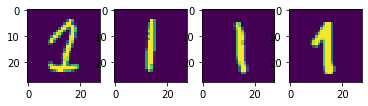

In [65]:
plt.figure(1)
print('Input Images')
plt.subplot(141)
plt.imshow(Xdisplay[0])
plt.subplot(142)
plt.imshow(Xdisplay[1])
plt.subplot(143)
plt.imshow(Xdisplay[2])
plt.subplot(144)
plt.imshow(Xdisplay[3])

In [66]:
X_samples_encoded = encoder.predict(X_samples, batch_size=batch_size)
X_samples_decoded = decoder.predict(X_samples_encoded, batch_size=batch_size)

ValueError: ignored

In [256]:
X_samples_decoded.shape

(100, 2)

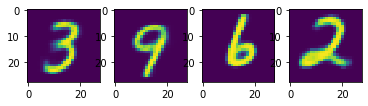

In [0]:
plt.figure(1)
plt.subplot(141)
plt.imshow(X_samples_decoded[22][:,:,0])
plt.subplot(142)
plt.imshow(X_samples_decoded[43][:,:,0])
plt.subplot(143)
plt.imshow(X_samples_decoded[64][:,:,0])
plt.subplot(144)
plt.imshow(X_samples_decoded[60][:,:,0])

Xdisplay.append(X_samples_decoded[22][:,:,0])
Xdisplay.append(X_samples_decoded[43][:,:,0])
Xdisplay.append(X_samples_decoded[64][:,:,0])
Xdisplay.append(X_samples_decoded[60][:,:,0])


In [0]:

len(Xdisplay)

28

In [0]:
type(X_samples_decoded[10][:,:,0])

numpy.ndarray

In [0]:
#similarity measures
from skimage import measure

def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err

In [0]:
mse_errors=[]
ssim_errors=[]
for i in range(len(X_samples)):
  original = X_samples[i][:,:,0]
  decoded = X_samples_decoded[i][:,:,0]
  mse_errors.append(mse(original,decoded))
  ssim_errors.append(measure.compare_ssim(original,decoded))
  
sum(mse_errors)/len(mse_errors)

0.015255273553309441

In [0]:

avg_mse=[]
avg_ssim=[]
avg_mse.append(0.012788251023012816)
avg_ssim.append(1-0.012788251023012816)

In [0]:
avg_mse.append(sum(mse_errors)/len(mse_errors))
avg_ssim.append(sum(ssim_errors)/len(ssim_errors))

In [0]:
avg_mse 

[0.012788251023012816,
 0.013688450406699188,
 0.012918628591383447,
 0.015255273553309441]

IndexError: ignored

Text(0, 0.5, 'Mean squared error')

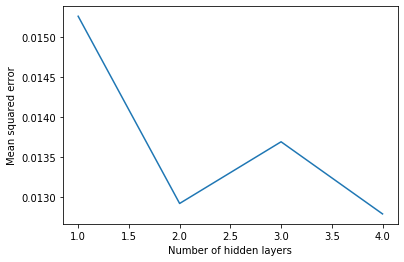

In [0]:
latents = [1,2,4,6,8,10]
layers = [1,2,3,4]
plt.plot(layers, avg_mse[::-1])
plt.xlabel('Number of hidden layers')
plt.ylabel('Mean squared error')

Text(0, 0.5, 'Structural Similarity Index')

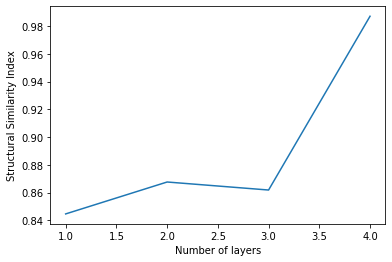

In [0]:
plt.plot(layers, avg_ssim[::-1])
plt.xlabel('Number of layers')
plt.ylabel('Structural Similarity Index')

Output with 1 layer


